In [30]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import *

from qumcmc.classical_mcmc_routines import classical_mcmc
# from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qulacs backend (**faster)
from QuantumSamplingRoutines import *
from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics

import pickle, json 
import networkx as nx

In [25]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, transpiler
from qiskit.visualization import *

In [3]:
from qiskit_ibm_provider import IBMProvider
# # provider = IBMProvider(token= '0c4a11984552ee16d40f9f7ad8848d8393c9010d55e924306fbc7486c2c55927173b79841d947e255fdbc927079265ed02aa66f10895a50367a0fd97bc6de628')
# # provider.save_account(token= '0c4a11984552ee16d40f9f7ad8848d8393c9010d55e924306fbc7486c2c55927173b79841d947e255fdbc927079265ed02aa66f10895a50367a0fd97bc6de628', overwrite= True)
provider = IBMProvider()


#### **Testing Backend**

In [4]:
ibmq_guadalupe = provider.get_backend('ibmq_guadalupe'); ibmq_lima = provider.get_backend('ibmq_lima')

In [60]:
trial_graph = nx.Graph(name= "ising_1")

In [61]:
trial_graph.add_nodes_from([0,1,2,3,4,6,7,10])

In [62]:
trial_graph.add_edges_from([(0,1),(1,4),(4,7),(7,10),(7,6),(1,2),(2,3)])

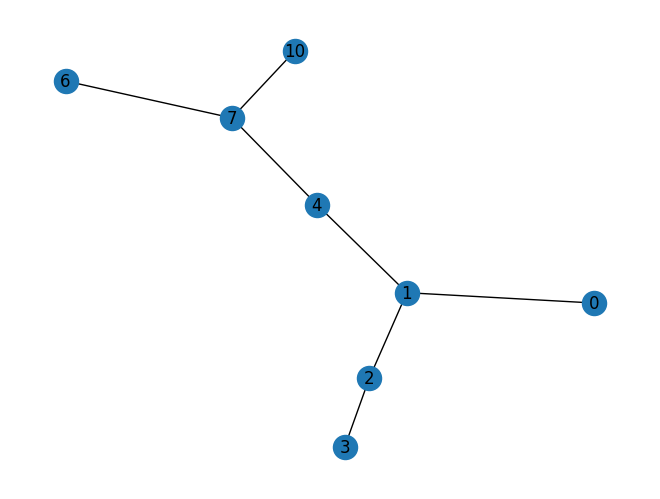

In [63]:
pos = nx.spring_layout(trial_graph)
nx.draw(trial_graph, pos, with_labels= True)

<AxesSubplot: >

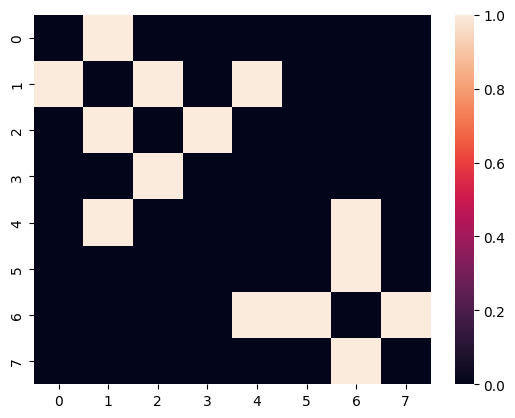

In [64]:
nx.to_numpy_array(trial_graph)

In [ ]:
a.to_numpy

#### **Test Trial**

In [31]:
nspin = 2
seed = 10923; name = 'n'+str(nspin)+'sd'+str(seed)
model = random_ising_model(n_spins=nspin, seed= seed, print_model= False)
model.name = name

model.model_summary(plot = False)

            MODEL : n2sd10923
Non-zero Interactions (J) : 1 / 1
Non-zero Bias (h) : 2 / 2
---------------------------------------------
Average Interaction Strength <|J|> :  0.3425
Average Bias Strength <|h|>:  0.19
alpha :  1.909313313651758
---------------------------------------------


In [32]:
samplingjob = QuantumSamplingJob(model=model, backend= ibmq_guadalupe)

In [33]:
gamma= 0.4 ; time= 1.0 

qcs = samplingjob.run_quantum_circuit(gamma, time, return_quantum_circuit= True)

In [12]:
qcs.draw()

┌───┐┌─┐┌────────────────┐                   ░ ┌─┐   
q1_0: ┤ H ├┤M├┤ exp(-ia1X+b1Z) ├───────────────────░─┤M├───
      ├───┤└╥┘└──────┬─┬───────┘┌────────────────┐ ░ └╥┘┌─┐
q1_1: ┤ H ├─╫────────┤M├────────┤ exp(-ia0X+b0Z) ├─░──╫─┤M├
      └───┘ ║        └╥┘        └────────────────┘ ░  ║ └╥┘
c2: 2/══════╩═════════╩═══════════════════════════════╬══╬═
            0         1                               ║  ║ 
c3: 2/════════════════════════════════════════════════╩══╩═
                                                      0  1

In [34]:
qcs_tr = transpile(qcs, backend= ibmq_guadalupe, optimization_level= 3, initial_layout= [3,5])

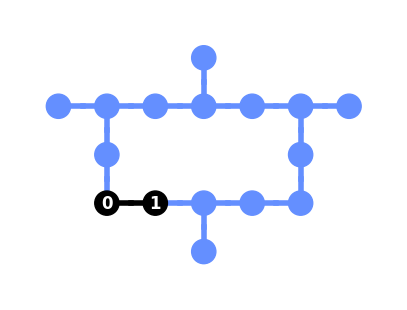

In [37]:
plot_circuit_layout(qcs_tr, ibmq_guadalupe)

In [35]:
qcs_tr.draw()

global phase: 3π/2
                                                                            »
  ancilla_0 -> 0 ───────────────────────────────────────────────────────────»
                                                                            »
  ancilla_1 -> 1 ───────────────────────────────────────────────────────────»
                                                                            »
  ancilla_2 -> 2 ───────────────────────────────────────────────────────────»
                 ┌─────────┐┌────┐┌─────────┐┌─┐┌────────────┐    ┌────┐    »
       q7_0 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤M├┤ Rz(1.6942) ├────┤ √X ├────»
                 └─────────┘└────┘└─────────┘└╥┘└────────────┘    └────┘    »
  ancilla_3 -> 4 ─────────────────────────────╫─────────────────────────────»
                 ┌─────────┐┌────┐┌─────────┐ ║      ┌─┐      ┌────────────┐»
       q7_1 -> 5 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─╫──────┤M├──────┤ Rz(1.3336) ├»
                 └─────────┘└────┘└─────────┘ ║      └╥┘      └────────────┘»
  ancilla_4 -> 6 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
  ancilla_5 -> 7 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
  ancilla_6 -> 8 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
  ancilla_7 -> 9 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
 ancilla_8 -> 10 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
 ancilla_9 -> 11 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
ancilla_10 -> 12 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
ancilla_11 -> 13 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
ancilla_12 -> 14 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
ancilla_13 -> 15 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
           c4: 2/═════════════════════════════╩═══════╩═════════════════════»
                                              0       1                     »
           c5: 2/═══════════════════════════════════════════════════════════»
                                                                            »
«                                                                              »
«  ancilla_0 -> 0 ─────────────────────────────────────────────────────────────»
«                                                                              »
«  ancilla_1 -> 1 ─────────────────────────────────────────────────────────────»
«                                                                              »
«  ancilla_2 -> 2 ─────────────────────────────────────────────────────────────»
«                 ┌─────────────┐     ┌────┐    ┌────────────┐               ░ »
«       q7_0 -> 3 ┤ Rz(-2.5032) ├─────┤ √X ├────┤ Rz(1.6942) ├───────────────░─»
«                 └─────────────┘     └────┘    └────────────┘               ░ »
«  ancilla_3 -> 4 ─────────────────────────────────────────────────────────────»
«                      ┌────┐    ┌─────────────┐    ┌────┐    ┌────────────┐ ░ »
«       q7_1 -> 5 ─────┤ √X ├────┤ Rz(-2.5074) ├────┤ √X ├────┤ Rz(1.3336) ├─░─»
«                      └────┘    └─────────────┘    └────┘    └────────────┘ ░ »
«  ancilla_4 -> 6 ────────────────────────

In [12]:
# with open('DATA/raw-circuit-outputs/mn2sd10923id1.pickle', 'rb') as hl:
#     qc = pickle.load(hl)